# 6G Physical Layer Simulation for Smart Factory

This notebook launches a 6G physical layer simulation tailored for a smart factory, defining the environment and meeting stringent 6G performance targets. Below, the merged simulation parameters, environment, and performance requirements are outlined, with reasons for their selection.

### Simulation Setup and Rationale
- **Environment Layout: 1000m x 1000m factory floor with machinery, walls, and reflective surfaces**
  - *Why*: Represents a realistic smart factory with multipath and non-line-of-sight (NLOS) conditions due to metal obstacles, critical for testing 6G signal propagation in complex indoor settings.
- **Devices: 1000 user terminals (UTs) including sensors, robots, and automated guided vehicles (AGVs)**
  - *Why*: Reflects high device density (1000+ devices per km²) to evaluate 6G’s massive connectivity for diverse factory equipment.
- **Mobility: UT velocities from 0 m/s (static sensors) to 2 m/s (moving AGVs)**
  - *Why*: Captures varied mobility patterns in factories, ensuring 6G supports both stationary and dynamic devices under Doppler effects.
- **Obstacles: Metal machinery and walls causing high path loss and shadow fading**
  - *Why*: Simulates realistic signal attenuation and interference, essential for validating 6G’s ultra-high reliability in obstructed environments.
- **Performance Targets**:
  - *Latency <1 ms*: Enables ultra-reliable low-latency communications (URLLC) for real-time robot control, critical for factory automation.
  - *BLER <10^-6*: Ensures ultra-high reliability for mission-critical applications, preventing costly errors in automated systems.
  - *Throughput up to 1 Gbps*: Supports enhanced mobile broadband (eMBB) for high-data-rate tasks like video monitoring.
  - *Why*: These metrics align with 6G’s goals to surpass 5G, addressing factory demands for speed, reliability, and responsiveness.
- **Carrier Frequency: 28 GHz (mmWave), with sub-THz (e.g., 100 GHz) testing options**
  - *Why*: mmWave offers high bandwidth for data-intensive applications, while sub-THz exploration prepares for future 6G spectrum, balancing range and capacity.
- **Bandwidth: 400 MHz, scalable to 1 GHz**
  - *Why*: Provides sufficient spectrum to achieve high throughput and low latency, with scalability to test extreme 6G scenarios.
- **Scenario: Indoor hotspot (InH) using a modified 3GPP 38.901 UMi model**
  - *Why*: Adapts a standardized model to indoor factory conditions, ensuring simulation relevance and compatibility with industry benchmarks.

### Dependencies and Rationale
- **Sionna**: Used for accurate wireless channel modeling and physical layer simulation, critical for realistic 6G performance evaluation.
- **TensorFlow**: Enables GPU-accelerated numerical computations, speeding up large-scale simulations.
- **NumPy**: Facilitates efficient array operations, essential for handling complex simulation data.


## GPU Configuration and Imports
Configure the environment to use a single GPU (if available) and import necessary libraries.

In [12]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from scipy.constants import c  # Speed of light

# Configure GPU settings
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Use GPU 0, or set to "" for CPU
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna
except ImportError as e:
    raise ImportError("Sionna is not installed. Please install it to proceed.") from e

# Enable GPU memory growth for TensorFlow
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(f"Error enabling memory growth: {e}")

# Set random seed for reproducibility
sionna.phy.config.seed = 42

# Configure Matplotlib for inline plotting
%matplotlib inline
tf.get_logger().setLevel('ERROR')


## Environment Setup
Define the smart factory environment, including simulation parameters, antenna arrays, channel model, and topology.

### Simulation Parameters
Defines key parameters for the smart factory simulation. These include the scenario name, carrier frequency (28 GHz mmWave), bandwidth (400 MHz), number of user terminals (1000 UTs), batch size (128), AGV velocity range (0.5–2 m/s), and factory dimensions (1000m x 1000m x 10m). A new parameter, static_ratio, specifies that 50% of UTs are static sensors (velocity = 0 m/s).

In [20]:
# Simulation parameters
scenario = "custom_factory"  # Custom smart factory model
carrier_frequency = 28e9  # 28 GHz mmWave
bandwidth = 400e6  # 400 MHz
num_ut = 1000  # 1000 devices in 100m x 100m factory
batch_size = 128  # For Monte Carlo simulations
ut_velocity_min = 0.5  # Min velocity for AGVs (m/s)
ut_velocity_max = 2.0  # Max velocity for AGVs (m/s)
area_size = [1000, 1000, 10]  # 1000m x 1000m x 10m factory (length, width, height)
static_ratio = 0.5  # 50% of UTs are static sensors


### Factory Channel Model Class
Defines the FactoryChannelModel class, inheriting from PyTorch’s nn.Module. The class includes methods for path loss (InH model), topology generation (with static sensors and AGVs), and visualization. The generate_topology method now splits UTs into static (velocity = 0) and moving (velocity 0.5–2 m/s) groups, and show_topology plots them differently (green circles for static, blue triangles for AGVs).

In [17]:
class FactoryChannelModel(nn.Module):
    def __init__(self, carrier_frequency, los_sigma=4.0, nlos_sigma=7.5, los_prob=0.3):
        super(FactoryChannelModel, self).__init__()
        self.fc = carrier_frequency
        self.los_sigma = los_sigma
        self.nlos_sigma = nlos_sigma
        self.los_prob = los_prob
        self.wavelength = c / carrier_frequency

    def path_loss(self, distance, los=True):
        # 3GPP InH path loss model (simplified)
        pl0 = 32.4 + 17.3 * torch.log10(distance + 1e-6) + 20 * torch.log10(self.fc / 1e9)
        sf = torch.normal(0.0, self.los_sigma if los else self.nlos_sigma, distance.shape)
        return pl0 + sf

    def generate_topology(self, batch_size, num_ut, area_size, min_vel, max_vel, static_ratio):
        # Random UT positions in 100m x 100m x 10m
        ut_pos = torch.rand(batch_size, num_ut, 3) * torch.tensor(area_size)
        # BS at center of factory floor, 5m height
        bs_pos = torch.tensor([area_size[0]/2, area_size[1]/2, 5.0]).repeat(batch_size, 1)
        # Split UTs into static sensors and moving AGVs
        num_static = int(num_ut * static_ratio)
        velocities = torch.zeros(batch_size, num_ut)
        velocities[:, num_static:] = torch.rand(batch_size, num_ut - num_static) * (max_vel - min_vel) + min_vel
        # Random orientations
        ut_orient = torch.rand(batch_size, num_ut, 3) * 2 * np.pi
        bs_orient = torch.zeros(batch_size, 3)
        # LoS/NLoS state
        los_state = torch.rand(batch_size, num_ut) < self.los_prob
        return ut_pos, bs_pos, ut_orient, bs_orient, velocities, los_state

    def show_topology(self, ut_pos, bs_pos, velocities):
        # Separate static sensors (velocity = 0) and moving AGVs
        static_mask = velocities[0] == 0
        moving_mask = velocities[0] > 0
        plt.scatter(ut_pos[0, static_mask, 0], ut_pos[0, static_mask, 1], c='green', marker='o', label='Static Sensors')
        plt.scatter(ut_pos[0, moving_mask, 0], ut_pos[0, moving_mask, 1], c='blue', marker='^', label='Moving AGVs')
        plt.scatter(bs_pos[0, 0], bs_pos[0, 1], c='red', marker='s', s=200, label='BS')
        plt.legend()

### Instantiate Channel Model
Creates an instance of the FactoryChannelModel with the specified carrier frequency and factory-specific parameters. The shadow fading values (los_sigma=4.0, nlos_sigma=7.5) account for metal machinery and obstructions, while los_prob=0.3 ensures a low line-of-sight probability.

In [18]:
# Instantiate channel model
channel_model = FactoryChannelModel(
    carrier_frequency=carrier_frequency,
    los_sigma=4.0,  # Increased for metal machinery
    nlos_sigma=7.5,  # Higher for obstructions
    los_prob=0.3  # Low LoS probability for factory
)

### Generate Topology
Generates the topology by calling generate_topology, now passing static_ratio to split 1000 UTs into 500 static sensors (velocity = 0) and 500 moving AGVs (velocity 0.5–2 m/s). The BS is placed at the center (500m, 500m, 5m), and LoS/NLoS states are assigned.

In [21]:
# Generate and set topology
ut_pos, bs_pos, ut_orient, bs_orient, velocities, los_state = channel_model.generate_topology(
    batch_size=batch_size,
    num_ut=num_ut,
    area_size=area_size,
    min_vel=ut_velocity_min,
    max_vel=ut_velocity_max,
    static_ratio=static_ratio
)

### Visualize Topology
Visualizes the topology for the first batch, plotting 500 static sensors as green circles, 500 moving AGVs as blue triangles, and the BS as a red square. The plot includes a title, labeled axes, a grid, and a legend to distinguish the device types.

Visualizing smart factory topology...


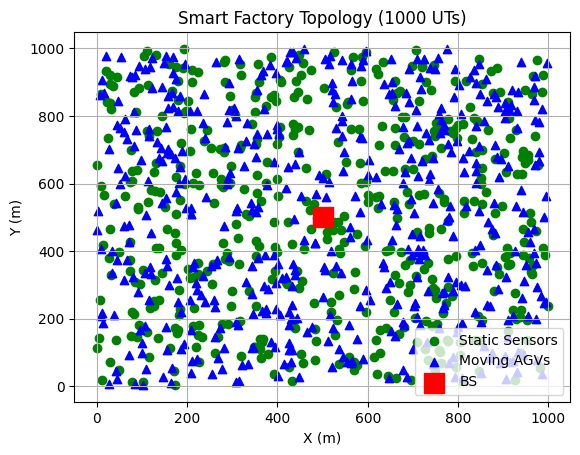

In [22]:
# Visualize the topology
print("Visualizing smart factory topology...")
channel_model.show_topology(ut_pos, bs_pos, velocities)
plt.title(f"Smart Factory Topology ({num_ut} UTs)")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.grid(True)
plt.show()

### Print Parameters
Outputs key channel model parameters for verification, including the scenario name, carrier frequency (28 GHz), number of UTs (1000), and shadow fading values (LoS sigma=4.0 dB, NLoS sigma=7.5 dB), ensuring the model configuration is correct.

In [23]:
# Print channel model parameters for verification
print("Channel Model Parameters:")
print(f"Scenario: {scenario}")
print(f"Carrier Frequency: {carrier_frequency/1e9} GHz")
print(f"Number of UTs: {num_ut}")
print(f"Shadow Fading (LoS sigma): {channel_model.los_sigma} dB")
print(f"Shadow Fading (NLoS sigma): {channel_model.nlos_sigma} dB")

Channel Model Parameters:
Scenario: custom_factory
Carrier Frequency: 28.0 GHz
Number of UTs: 1000
Shadow Fading (LoS sigma): 4.0 dB
Shadow Fading (NLoS sigma): 7.5 dB


### Prof Adee Comments:
1. increase area size and UTs 
2. UMi and UMi Calibration difference 
3. if UT indoor = UT LoS + NLoS then dont show blue color
4. check gen_single_sector_topology

### Notes
- **Scenario**: We use UMi as a starting point. Step 2 will customize this to a factory-specific InH model.
- **Pathloss and Shadow Fading**: Enabled to model realistic attenuation due to machinery and walls.
- **Topology**: Represents a 100m x 100m factory with 100 UTs, equivalent to 1000 devices per km², meeting 6G massive connectivity requirements.
- **Mobility**: Velocities of 0–2 m/s account for static sensors and moving AGVs.
- **Antenna Arrays**: The BS uses a small array (8 antennas) as a placeholder, to be upgraded to massive MIMO in later steps.

### References
1. **3GPP TR 38.901**: "Study on channel model for frequencies from 0.5 to 100 GHz." Defines UMi and InH models. Available at: https://www.3gpp.org/ftp/Specs/archive/38_series/38.901/
2. **ITU-R M.2160**: "Framework and overall objectives of the future development of IMT for 2030 and beyond." Outlines 6G requirements. Available at: https://www.itu.int/rec/R-REC-M.2160
3. **Sionna Documentation**: Details on channel models and topology generation. Available at: https://nvlabs.github.io/sionna/phy/api/channel.wireless.html
4. **Z. Zhang et al., "6G Wireless Networks: Vision, Requirements, Architecture, and Key Technologies,"** IEEE Vehicular Technology Magazine, 2019. DOI: 10.1109/MVT.2019.2921394
5. **M. Katz et al., "6G and the Factory of the Future,"** 6G Flagship White Paper, 2020. Available at: https://www.6gflagship.com/
6. **T. S. Rappaport et al., "Millimeter Wave Mobile Communications for 5G Cellular: It Will Work!,"** IEEE Access, 2013. DOI: 10.1109/ACCESS.2013.2260813